### Data Loading and Cleaning

In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt

In [3]:
#create connection to database file
database = "Season.db"
connection = sql.connect(database)

In [4]:
query1819 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1819 '''
query1718 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1718 '''
query1617 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1617 '''
query1516 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1516 '''
query1415 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1415 '''
query1314 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1314 '''
query1213 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1213 '''
query1112 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1112 '''
query1011 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_1011 '''
query0910 = '''Select Date,HomeTeam,AwayTeam,FTR FROM season_0910 '''

In [5]:
#Each dataframe is ordered by date of soccer game, but not all data frames have the same date format
df1819 = pd.read_sql_query(query1819,connection)
df1718 = pd.read_sql_query(query1718,connection)
df1617 = pd.read_sql_query(query1617,connection)
df1516 = pd.read_sql_query(query1516,connection)
df1415 = pd.read_sql_query(query1415,connection)
df1314 = pd.read_sql_query(query1314,connection)
df1213 = pd.read_sql_query(query1213,connection)
df1112 = pd.read_sql_query(query1112,connection)
df1011 = pd.read_sql_query(query1011,connection)
df0910 = pd.read_sql_query(query0910,connection)

In [6]:
#function to standardize date structure to (YYYY/mm/dd)
import datetime
import re

def fix_date(dataframe):
    y_dash = re.compile('\d{4}-.*-.*')  #detect data frames with date format (YYYY-mm-dd)
    slash_Y = re.compile('.*/.*/\d{4}') #detect data frames with date format (dd/mm/YYYY)
    dmy = re.compile('.*/.*/\d{2}$')    #detect data frames with date format (dd/mm/yy)
    for date in range(len(dataframe)):
        if y_dash.match(dataframe['Date'][date]) is not None:     #if formatted as (YYYY-mm-dd) change to (YYYY/mm/dd)
            dataframe['Date'][date] = datetime.datetime.strptime(dataframe['Date'][date], '%Y-%m-%d').strftime('%Y/%m/%d')
        elif slash_Y.match(dataframe['Date'][date]) is not None:  #if formatted as (dd/mm/YYYY) change to (YYYY/mm/dd)
            dataframe['Date'][date] = datetime.datetime.strptime(dataframe['Date'][date], '%d/%m/%Y').strftime('%Y/%m/%d')
        elif dmy.match(dataframe['Date'][date]) is not None:      #if formatted as (dd/mm/yy) change to (YYYY/mm/dd)
            dataframe['Date'][date] = datetime.datetime.strptime(dataframe['Date'][date], '%d/%m/%y').strftime('%Y/%m/%d')

In [7]:
league_data = [df0910,df1011,df1112,df1213,df1314,df1415,df1516,df1617,df1718,df1819]

for i in league_data:
    fix_date(i)

df1112.head()
#Now all dates are standardized in the format (YYYY/mm/dd)

,Date,HomeTeam,AwayTeam,FTR
0,2011/08/13,Blackburn,Wolves,A
1,2011/08/13,Fulham,Aston Villa,D
2,2011/08/13,Liverpool,Sunderland,D
3,2011/08/13,Newcastle,Arsenal,D
4,2011/08/13,QPR,Bolton,A


In [8]:
# Web scrape for data on managerial changes.
import pandas as pd
from bs4 import BeautifulSoup
import requests

url = "https://en.wikipedia.org/wiki/List_of_Premier_League_managers"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
tb = soup.find('table', class_='wikitable sortable plainrowheaders')

In [9]:
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]

for row in tb.findAll('tr'):
    cells=row.findAll(['th', 'td'])
    if len(cells)==8:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))
        F.append(cells[5].find(text=True))
        G.append(cells[6].find(text=True))
        H.append(cells[7].find(text=True))

df=pd.DataFrame(A,columns=['Name'])
df['Nat']=B
df['Club']=C
df['From']=D
df['Until']=E
df['Duration']=F
df['Years']=G
df['Ref']=H

df.head()

,Name,Nat,Club,From,Until,Duration,Years,Ref
0,Name,Nat.,Club,From,Until,Duration,Years in,Ref.
1,George Graham,,Arsenal,14 May 1986,21 February 1995,3205,1992–1995,[2]
2,Stewart Houston,,Arsenal,22 February 1995,8 June 1995,106,1995,[3]
3,Bruce Rioch,,Arsenal,8 June 1995,12 August 1996,431,1995–1996,[2]
4,Stewart Houston,,Arsenal,12 August 1996,13 September 1996,32,1996,[3]


In [10]:
#remove first row and irrelevant columns; reindex rows
managers = df.drop([0])
managers = managers.reset_index(drop=True)
managers = managers.drop(columns=['Nat','Years','Ref'])

In [11]:
for i in range(len(managers)):
    if bool(re.search('May|June|July|August', managers['Until'][i])) and bool(re.search('May|June|July|August', managers['From'][i])):
        managers = managers.drop([i]) # Drop managers that were hired at the beginning of a season and left at the end.
    elif(bool(re.search('May|June|July|August', managers['Until'][i])) and list(map(int,re.findall('\d+', managers['From'][i]))) < [2009,8,15]):
        managers = managers.drop([i]) # Drop managers that ended their term in May

managers = managers.reset_index(drop=True)

In [12]:
# Fixing date formats in 'From' column to (YYYY/mm/dd)
import datetime

def fix_datefrom(dataframe): # fix date format in 'From' column
    for i in range(len(dataframe)):
        dataframe['From'][i] = datetime.datetime.strptime(dataframe['From'][i], '%d %B %Y').strftime('%Y/%m/%d')
        

fix_datefrom(managers)
# Now all dates in 'From' column are in the format (YYYY/mm/dd)

In [13]:
# Fixing date formats in 'Until' column to (YYYY/mm/dd)

def fix_dateuntil(dataframe): #fix date format in 'Until' column; replace 'Present' with today's date
    for i in range(len(dataframe)):
        if dataframe['Until'][i] == 'Present':
            dataframe['Until'][i] = '2019/10/22' # fix the date to the end of 18/19 season date
        else:
            dataframe['Until'][i] = datetime.datetime.strptime(dataframe['Until'][i], '%d %B %Y').strftime('%Y/%m/%d')
            
fix_dateuntil(managers)
# Now all dates in 'Until' column are in the format (YYYY/mm/dd)

In [14]:
# Remove temporary managers (often times regular coaches that take the role of a manager until a replacement is found)
# We will set a threshold of 100 days (i.e. Duration < 100)

for i in range(len(managers)):
    if int(managers['Duration'][i]) < 100:
        managers = managers.drop([i])
        
managers = managers.reset_index(drop=True)

In [15]:
# Remove managers that were *not* sacked or hired during our desired timeframe (2009 - 2019)

for i in range(len(managers)):
    if list(map(int,re.findall('\d+', managers['Until'][i]))) < [2009,8,15]:  #if manager was in charge until before 2009 Aug 15
        managers = managers.drop([i])
    elif list(map(int,re.findall('\d+', managers['From'][i]))) > [2019,5,12]: #if manager was in charge after 2019 May 12
        managers = managers.drop([i])
        
managers = managers.reset_index(drop=True)

In [16]:
# create a dictionary of how many managerial changes each team went through given our filters
d = {}

for i in range(len(managers)):
    if d.get(managers['Club'][i]) != None:
        d[managers['Club'][i]] += 1
    else:
        d[managers['Club'][i]] = 1

In [17]:
# convert the dictionary into a dataframe for easier manipulation
counts = pd.Series(d)
manager_count = pd.DataFrame({'Changes': counts})

In [18]:
managers.head()

,Name,Club,From,Until,Duration
0,Unai Emery,Arsenal,2018/05/23,2019/10/22,537
1,Paul Lambert,Aston Villa,2012/06/02,2015/02/11,985
2,Tim Sherwood,Aston Villa,2015/02/14,2015/10/25,253
3,Rémi Garde,Aston Villa,2015/11/02,2016/03/29,148
4,Dean Smith,Aston Villa,2018/10/10,2019/10/22,397


In [19]:
# Find names of teams with just one managerial change data
del_teams = []
for i in range(len(manager_count)):
    if manager_count['Changes'][i]==1:
        del_teams.append(str(manager_count.index[i]))

del_teams

['Arsenal',
 'Blackpool',
 'Bournemouth',
 'Huddersfield Town',
 'Portsmouth',
 'Sheffield United',
 'Stoke City']

In [20]:
# Find the index of teams with only one managerial change
del_index=[]
for i in range(len(managers)):
    for j in range(len(del_teams)):
        if (del_teams[j] == managers['Club'][i]):
            del_index.append(i)

# Remove teams with just one managerial change from managers data frame.
sackings = managers.drop(del_index)
sackings = sackings.reset_index(drop=True)
sackings = sackings.drop(columns=['Name','Duration'])

In [21]:
#Remove spacing in team names
for i in range(len(sackings)):
    sackings['Club'][i] = sackings['Club'][i].replace(" ", "")

In [22]:
sackings.head()

,Club,From,Until
0,AstonVilla,2012/06/02,2015/02/11
1,AstonVilla,2015/02/14,2015/10/25
2,AstonVilla,2015/11/02,2016/03/29
3,AstonVilla,2018/10/10,2019/10/22
4,BlackburnRovers,2008/12/17,2010/12/13


In [23]:
# Create global dataframes for each team
# drop the 'Club' column
# append the 'Until' column to 'From' column
# create a column 'Status' with elements 'C' for "change"
gbl = globals()
for i in sackings.Club.unique():
    gbl[i] = sackings[sackings.Club==i].drop(columns=['Club'])
    gbl[i] = gbl[i]['From'].append(gbl[i]['Until']).reset_index(drop=True)
    gbl[i] = pd.DataFrame(gbl[i],columns=['Date'])
    gbl[i] = pd.concat([gbl[i], pd.DataFrame(['C']*len(gbl[i]), columns=['Status'])], axis=1)

In [24]:
# delete rows within each team's dataframe if the changes occured in May, June, July, or August
# delete rows if the date is the present date (2019/10/22)
# delete rows if the date is before 2009/08/15

for i in sackings.Club.unique():
    iterlen=len(gbl[i])
    pattern = re.compile('\d{4}/(05|06|07|08)/\d{2}')
    present = re.compile('2019/10/22')
    for j in range(iterlen):
        if gbl[i]['Status'][j] == 'C' and bool(pattern.match(gbl[i]['Date'][j])):
            gbl[i] = gbl[i].drop([j])
        elif gbl[i]['Status'][j] == 'C' and bool(present.match(gbl[i]['Date'][j])):
            gbl[i] = gbl[i].drop([j])
        elif list(map(int,re.findall('\d+', gbl[i]['Date'][j]))) < [2009,8,15]:
            gbl[i] = gbl[i].drop([j])
    gbl[i] = gbl[i].reset_index(drop=True)

In [25]:
# each team should now have a global data frame called by their respective names and should look like this:
AstonVilla

,Date,Status
0,2015/02/14,C
1,2015/11/02,C
2,2018/10/10,C
3,2015/02/11,C
4,2015/10/25,C
5,2016/03/29,C


### Cleaning Premier League Data

In [26]:
# Now we rearrange the Premier League fixtures data which we queried earlier
# recall that league_data = [df0910,df1011,df1112,df1213,df1314,df1415,df1516,df1617,df1718,df1819]
final_data = pd.concat(league_data, axis=0).reset_index(drop=True)

#Remove spacing in club names to match the name format of the global dataframes we created above
for i in range(len(final_data)):
    final_data['HomeTeam'][i] = final_data['HomeTeam'][i].replace(" ", "")
    final_data['AwayTeam'][i] = final_data['AwayTeam'][i].replace(" ", "")

In [27]:
sackings.Club.unique()

array(['AstonVilla', 'BlackburnRovers', 'BoltonWanderers', 'Burnley',
       'CardiffCity', 'Chelsea', 'CrystalPalace', 'Everton', 'Fulham',
       'HullCity', 'LeicesterCity', 'Liverpool', 'ManchesterCity',
       'ManchesterUnited', 'Middlesbrough', 'NewcastleUnited',
       'NorwichCity', 'QueensParkRangers', 'Reading', 'Southampton',
       'Sunderland', 'SwanseaCity', 'TottenhamHotspur', 'Watford',
       'WestBromwichAlbion', 'WestHamUnited', 'WolverhamptonWanderers'],
      dtype=object)

In [28]:
# Find the union of final_data and sackings, then remove their intersection to reveal the different abbreviations/name of teams 
union = np.union1d(final_data.HomeTeam.unique(),sackings.Club.unique())
inter = np.intersect1d(final_data.HomeTeam.unique(),sackings.Club.unique())
print([item for item in union if item not in inter])

['Arsenal', 'Birmingham', 'Blackburn', 'BlackburnRovers', 'Blackpool', 'Bolton', 'BoltonWanderers', 'Bournemouth', 'Brighton', 'Cardiff', 'CardiffCity', 'Huddersfield', 'Hull', 'HullCity', 'Leicester', 'LeicesterCity', 'ManCity', 'ManUnited', 'ManchesterCity', 'ManchesterUnited', 'Newcastle', 'NewcastleUnited', 'Norwich', 'NorwichCity', 'Portsmouth', 'QPR', 'QueensParkRangers', 'Stoke', 'Swansea', 'SwanseaCity', 'Tottenham', 'TottenhamHotspur', 'WestBrom', 'WestBromwichAlbion', 'WestHam', 'WestHamUnited', 'Wigan', 'WolverhamptonWanderers', 'Wolves']


In [29]:
# create dataframe to convert said names to match the ones in 'sackings' and convert
convert = pd.DataFrame([['Blackburn','BlackburnRovers'],['Bolton','BoltonWanderers'],['Cardiff','CardiffCity'],
                        ['Hull','HullCity'],['Leicester','LeicesterCity'],['ManCity','ManchesterCity'],
                        ['ManUnited','ManchesterUnited'],['Newcastle','NewcastleUnited'],['Norwich','NorwichCity'],
                        ['QPR','QueensParkRangers'],['Swansea','SwanseaCity'],['Tottenham','TottenhamHotspur'],
                        ['WestBrom','WestBromwichAlbion'],['WestHam','WestHamUnited'],['Wolves','WolverhamptonWanderers']])

for i in range(len(final_data)):
    for j in range(len(convert)):
        if final_data['HomeTeam'][i] == convert.iloc[j,0]:
            final_data['HomeTeam'][i] = convert.iloc[j,1]
        elif final_data['AwayTeam'][i] == convert.iloc[j,0]:
            final_data['AwayTeam'][i] = convert.iloc[j,1]

In [30]:
# Add rows consisting of ['Date','Status'] into our respective team dataframes
# rows should include the date of their game and 3 for a win, 1 for a draw, and 0 for a loss
gbl = globals()
for i in range(len(final_data)):
    # If the FullTimeResult (FTR) is 'H' then home team gets 3 points, away team gets 0
    if (final_data['FTR'][i] == 'H'):   # for a given game, if the "full time result" is 'H' then the HomeTeam wins
        if (final_data['HomeTeam'][i] in sackings.Club.unique()):  # if a dataframe exists for this team
            gbl[final_data['HomeTeam'][i]] = gbl[final_data['HomeTeam'][i]].append(pd.Series([final_data['Date'][i], 3], index=['Date', 'Status']), ignore_index=True)
        elif(final_data['AwayTeam'][i] in sackings.Club.unique()): # if a dataframe exists for this team
            gbl[final_data['AwayTeam'][i]] = gbl[final_data['AwayTeam'][i]].append(pd.Series([final_data['Date'][i], 0], index=['Date', 'Status']), ignore_index=True)
    # If the FullTimeResult (FTR) is 'A' then away team gets 3 points, home team gets 0
    elif (final_data['FTR'][i] == 'A'): # for a given game, if the "full time result" is 'A' then the AwayTeam wins
        if (final_data['HomeTeam'][i] in sackings.Club.unique()):  # if a dataframe exists for this team
            gbl[final_data['HomeTeam'][i]] = gbl[final_data['HomeTeam'][i]].append(pd.Series([final_data['Date'][i], 0], index=['Date', 'Status']), ignore_index=True)
        elif(final_data['AwayTeam'][i] in sackings.Club.unique()): # if a dataframe exists for this team
            gbl[final_data['AwayTeam'][i]] = gbl[final_data['AwayTeam'][i]].append(pd.Series([final_data['Date'][i], 3], index=['Date', 'Status']), ignore_index=True)
    # If the FullTimeResult (FTR) is 'D' then both teams gets 1 point
    elif (final_data['FTR'][i] == 'D'): # for a given game, if the "full time result" is 'D' then it is a draw
        if (final_data['HomeTeam'][i] in sackings.Club.unique()):  # if a dataframe exists for this team
            gbl[final_data['HomeTeam'][i]] = gbl[final_data['HomeTeam'][i]].append(pd.Series([final_data['Date'][i], 1], index=['Date', 'Status']), ignore_index=True)
        elif(final_data['AwayTeam'][i] in sackings.Club.unique()): # if a dataframe exists for this team
            gbl[final_data['AwayTeam'][i]] = gbl[final_data['AwayTeam'][i]].append(pd.Series([final_data['Date'][i], 1], index=['Date', 'Status']), ignore_index=True)

In [31]:
#sort by date
for i in sackings.Club.unique():
    gbl[i] = gbl[i].sort_values(by=['Date']).reset_index(drop=True)

In [32]:
# As you can see below, an issue is the double row of 'Status' = 'C'
ManchesterUnited.tail(17)

,Date,Status
211,2018/12/05,1
212,2018/12/08,3
213,2018/12/18,C
214,2018/12/19,C
215,2018/12/26,3
216,2018/12/30,3
217,2019/01/19,3
218,2019/01/29,1
219,2019/02/24,1
220,2019/03/02,3


In [33]:
# For each team dataframe, remove one of the double 'Status' = 'C' rows as shown above
for i in sackings.Club.unique():
    iterlen=len(gbl[i])
    for j in range(iterlen-1):
        if (gbl[i]['Status'][j] == 'C'and gbl[i]['Status'][j+1] == 'C'):
            gbl[i] = gbl[i].drop([j])

In [34]:
# For each team dataframe, if the first or  last 'Status' = 'C', remove the row.
for k in sackings.Club.unique():
    if (gbl[k]['Status'][len(gbl[k])-1] == 'C'):
        gbl[k] = gbl[k].drop([len(gbl[k])-1])
    gbl[k] = gbl[k].reset_index(drop=True)
    
for k in sackings.Club.unique():
    if (gbl[k]['Status'][0] == 'C'):
        gbl[k] = gbl[k].drop([0])
    gbl[k] = gbl[k].reset_index(drop=True)

In [35]:
for k in sackings.Club.unique():
    if (gbl[k]['Status'][len(gbl[k])-1] == 'C'):
        gbl[k] = gbl[k].drop([len(gbl[k])-1])
    gbl[k] = gbl[k].reset_index(drop=True)

In [36]:
for i in sackings.Club.unique():
    temp = []
    for j in range(len(gbl[i])):
        if gbl[i].loc[j,'Status'] == 'C':
            temp.append(j)
    print([j-i for i, j in zip(temp[:-1], temp[1:])])

[14, 12]
[]
[]
[13]
[3, 10]
[16, 66]
[27, 43, 16]
[]
[9, 8, 8, 10]
[63]
[16, 34]
[104]
[]
[103]
[]
[93, 27]
[3]
[18, 29]
[]
[116, 13]
[33, 2, 6, 3, 33, 12]
[39, 5, 15, 9, 22]
[]
[]
[63, 24, 64, 2, 12]
[]
[]


In [37]:
#Remove special cases that are difficult to deal with using loops or functions

CardiffCity = CardiffCity.drop([10,11,12]).reset_index(drop=True)
Sunderland = Sunderland.drop([91,97,98,99,100]).reset_index(drop=True)
SwanseaCity = SwanseaCity.drop([95,96,97,98,99]).reset_index(drop=True)
WestBromwichAlbion = WestBromwichAlbion.drop([166,167,180]).reset_index(drop=True)

del NorwichCity
sackings = sackings.drop(list(sackings[sackings.Club=='NorwichCity'].index))
sackings = sackings.reset_index(drop=True)

In [38]:
# Create "before" and "after" dataframes (5 game results before and after managerial change) for each instance of a change
# call these dataframes "team"+index and "team"+index+"_2" and add a column with cumulative means

finaldata = []
for i in sackings.Club.unique():
    k = 0
    for j in range(len(gbl[i])):
        if (gbl[i]['Status'][j] == 'C'):
            k += 1
            gbl[i+str(k)] = gbl[i][j-5:j].reset_index(drop=True)
            gbl[i+str(k)]['Cumulative Mean'] = gbl[i+str(k)]['Status'][0:5].expanding().mean()
            gbl[i+str(k)+'_2'] = gbl[i][j+1:j+6].reset_index(drop=True)
            gbl[i+str(k)+'_2']['Cumulative Mean'] = gbl[i+str(k)+'_2']['Status'][0:5].expanding().mean()
            finaldata.append([i+str(k),i+str(k)+'_2'])

In [39]:
before = pd.DataFrame([])
after = pd.DataFrame([])
for i in finaldata:
    before = pd.concat([before,gbl[i[0]]['Status']], axis =1)
    after = pd.concat([after,gbl[i[1]]['Status']], axis =1)
before = before.astype(float)
after = after.astype(float)
before.columns = range(before.shape[1])
after.columns = range(after.shape[1])

In [40]:
%store before
%store after

Stored 'before' (DataFrame)
Stored 'after' (DataFrame)


To conduct analysis on our data we will want to use a paired t-test. A paired t-test tests whether the means of two dependent groups are significantly difference from each other. But for our t-test to be valid we need to check the normality of the differences. To do so, we use the Shapiro-Wilk test.

In [41]:
import scipy
from scipy import stats

change = after-before
stats.shapiro(change)

(0.9189518690109253, 1.137985712607037e-11)

Since the p-value above of 1.137985712607037e-11 is less than 0.05, we reject the null hypothesis and can conclude that the differences are NOT from a normal distribution. Hence, we must use the Wilcoxon Test instead of the paired t-test.

In [42]:
scipy.stats.wilcoxon(np.array(pd.melt(before)['value']),np.array(pd.melt(after)['value']))

WilcoxonResult(statistic=5658.0, pvalue=2.1057694023886934e-07)

In [43]:
scipy.stats.wilcoxon(pd.array(before.mean()),pd.array(after.mean()))

WilcoxonResult(statistic=141.5, pvalue=6.084365033589189e-07)

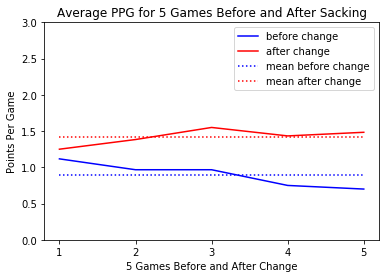

In [44]:
x = np.array(range(5))
y = np.array(before.mean(axis=1))
y2 = np.array(after.mean(axis=1))
y_m = before.mean(axis=1).mean()
y2_m = after.mean(axis=1).mean()
my_xticks = ['1','2','3','4','5']
plt.xticks(x, my_xticks)
plt.plot(x, y, color='blue',label="before change")
plt.hlines(y_m, 0,4, color='blue',label="mean before change", linestyle=":")
plt.plot(x, y2, color='red',label="after change")
plt.hlines(y2_m, 0,4, color='red',label="mean after change", linestyle=":")
plt.ylabel("Points Per Game")
plt.xlabel("5 Games Before and After Change")
plt.title("Average PPG for 5 Games Before and After Sacking")
plt.legend()

plt.ylim(0, 3)
plt.savefig('PPG_ba.png')

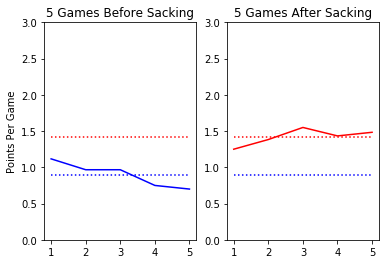

In [45]:
x = np.array(range(5))
y = np.array(before.mean(axis=1))
y2 = np.array(after.mean(axis=1))
y_m = before.mean(axis=1).mean()
y2_m = after.mean(axis=1).mean()
my_xticks = ['1','2','3','4','5']

plt.subplot(1, 2, 1)
plt.xticks(x, my_xticks)
plt.plot(x, y, color='blue')
plt.hlines(y_m, 0,4, color='blue', linestyle=":")
plt.hlines(y2_m, 0,4, color='red', linestyle=":")
plt.ylabel("Points Per Game")
plt.title("5 Games Before Sacking")
plt.ylim(0, 3)


plt.subplot(1, 2, 2)
plt.xticks(x, my_xticks)
plt.plot(x, y2, color='red')
plt.hlines(y_m, 0,4, color='blue', linestyle=":")
plt.hlines(y2_m, 0,4, color='red', linestyle=":")
plt.title("5 Games After Sacking")
plt.ylim(0, 3)

plt.show()

In [ ]:
import seaborn as sns

ya = np.array(before.mean(axis=0))
ya2 = np.array(after.mean(axis=0))
ya_m = before.mean(axis=0).mean()
ya2_m = after.mean(axis=0).mean()
sns.distplot(ya2, vertical=True, color="r", bins = 10)
sns.distplot(ya, vertical=True, color="b", bins = 10)

plt.hlines(ya_m, 0,1, color='blue',label="mean before change", linestyle=":")
plt.hlines(ya2_m, 0,1, color='red',label="mean after change", linestyle=":")
plt.ylabel("Points Per Game (PPG)")
plt.xlabel("Density")
plt.title("Densities of PPG")
plt.savefig('Densities_PPG.png')

In [ ]:
box_plot_data=[ya,ya2]
plt.boxplot(box_plot_data)
plt.xticks([1,2], ["Before","After"])
plt.ylabel("Points Per Game (PPG)")
plt.xlabel("Managerial Sacking")
plt.title("Boxplots of PPG Before and After")
plt.savefig('Boxplot_PPG.png')

In [ ]:
before_c = pd.DataFrame([])
after_c = pd.DataFrame([])
for i in finaldata:
    before_c = pd.concat([before_c,gbl[i[0]]['Cumulative Mean']], axis =1)
    after_c = pd.concat([after_c,gbl[i[1]]['Cumulative Mean']], axis =1)

In [ ]:
x = np.array(range(5))
yc = np.array(before_c.mean(axis=1))
yc2 = np.array(after_c.mean(axis=1))
my_xticks = ['1','2','3','4','5']
plt.xticks(x, my_xticks)
plt.plot(x, yc, color='blue',label="before change")
plt.plot(x, yc2, color='red',label="after change")
plt.ylabel("Points Per Game")
plt.xlabel("5 Games Before and After Change")
plt.title("Cumulative Average PPG for 5 Games Before and After Sacking")
plt.legend()

plt.ylim(0, 3)
plt.savefig('Cumavg_PPG.png')